## Final code for Opertaional CO2e estimation for dense models

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

## All Functions

In [30]:
## dense model regression coefficients

coeff_tensor = [-8.82079068e-20,  1.68591116e-09,  1.33954735e+02] # fit on absolute throughput value
# coeff_tensor = [-2.82717650e-22,  5.40356141e-12,  4.29342100e-01] # fit on percent utilization
coeff_pipe = [-5.60233749e-23,  8.45435587e-11,  1.34546129e+02] # fit on absolute throughput value
# coeff_pipe = [-1.79562099e-25,  2.70972945e-13,  4.31237594e-01] # fit on percent utilization

coeff_gpu_inter = [-3.48420436e-21,  6.13525744e-09,  3.91960713e+02]
coeff_gpu_intra = [1.31381254e-08, 1.77462653e+01]
coeff_batch = [0.0418642 , -2.46672581, 36.14288189]

func_tensor = np.poly1d(coeff_tensor) # function to estimate % util in inner-node
func_pipe = np.poly1d(coeff_pipe) #function to estimate % util in inter-node

func_gpu = np.poly1d(coeff_gpu_intra) # function to estimate total GPUs inner-node(linear) 
func_gpu_i = np.poly1d(coeff_gpu_inter) # function to estimate total GPUs inter-node 

func_batch = np.poly1d(coeff_batch) # function to estimate batch size per GPU

In [22]:
def get_model_size(experts, layers, h_size, V, s):
    '''calculate total sparse model parameter size and equivalent dense model size
    method:
    1. Let total FF layers l_ff = #layers/2, total MoE layers l_moe = #layers/2 
    2. Get total Non-Expert parameter size P_ff = P_l*l_ff where P_l is parameter per layer
    3. Get total parameter size for MoE FF Expert matrices P_moe_ff = 8*(hidden_state^2)*(#experts)
    4. Get total parameter size for MHA operations in MoE layers P_moe_mha = 4*(hidden_state^2)
    5. Get total Expert parameter for all MoE layer P_moe = (P_moe_ff + P_moe_mha)*l_moe
    6. Get total sparse model size P_sparse = P_ff + P_moe
    '''
    P_dense = 12*layers*(h_size**2)*(1 + (13/(12*h_size)) + ((V+s)/(12*layers*h_size)))
    # P_dense = 12*layers*(h_size**2)
    l_ff, l_moe = layers/2, layers/2
    P_l = P_dense/layers
    P_ff = P_l * l_ff
    
    P_moe_ff = 8*(h_size**2)*(experts)
    P_moe_mha = 4*(h_size**2)
    P_moe = (P_moe_ff + P_moe_mha)*l_moe
    
    P_sparse = P_ff + P_moe
    
    return P_sparse, P_dense

def get_pt(P, node_size, gpu_cap):
    '''return required model parallel degree'''
    P = P/1e9
    # model parallel size
    if P < node_size*gpu_cap:
        p_size = 1
        t_size = int(np.ceil(P/gpu_cap))
    else:
        t_size = node_size
        p_size = int(np.ceil(P/(node_size*gpu_cap)))

    model_size = t_size * p_size    
    return p_size, t_size

def get_n(P, p_size, t_size, gpu_type, gpu_mem):
    '''return required number of GPUs(p*t*d)'''
    model_size = p_size*t_size
    if p_size == 1:
        #intra model
        num_gpu = np.round(func_gpu(P)/model_size)*model_size
    else:
        #inter model
        num_gpu = np.round(func_gpu_i(P)/model_size)*model_size
#     if 'V100' in gpu_type:
#         num_gpu = np.round(num_gpu * 2.5) #V100 is 32GB
        
    if gpu_mem == 40:
        num_gpu *= 2
    return num_gpu

def get_sparse_gpu(P_sparse, node_size):
    dpmoe_gpu = np.round((P_sparse/1e9)/0.78, node_size)*node_size
    # ds_gpu = np.round(dpmoe_gpu/8, node_size)*node_size
    ds_gpu = dpmoe_gpu/8
    return np.round(dpmoe_gpu), np.round(ds_gpu)

def get_batch(P, p_size, d_size, num_gpu):
    '''return global batch size'''
    P = np.log(P)
    b_n = func_batch(P)
    b = num_gpu*np.exp(b_n)
    #round off to nearest multiple of p*d
    return np.round(b/(p_size*d_size))*(p_size*d_size)

def get_throughput(P, p_size, t_size, node_size, gpu_type, rel_thru):
    '''return throughput for the model size'''
    #intra model condition
    if (t_size <= node_size and p_size == 1):
        X = func_tensor(P)
    # inter model     
    else:
        X = func_pipe(P)

    #throughput scaling for V100 (needs revision)
    if 'V100' in gpu_type:
        X_new = X -  X*rel_thru
        peak_new = X_new /gpu_map[gpu_type]['peak_flop']
        X_scaled = peak_new*125
    else:
        X_scaled = X    
    
    return X_scaled

def get_sparse_throughput(ds_gpu):
    '''get sparse throughput(tokens/sec) for DPMoE and DeepSpeed
    using a slope of 2.64 and intercept of 39.88'''
    X_sparse = ds_gpu*(2.64) + 39.88
    return X_sparse

def get_train_time(P, tokens, num_gpu, throughput, model_type):
    '''return total training compute FLOPs and time'''
    ## Factor of 6 for dense and 3 for sparse models 
    flop_per_parameter = 6
    if 'T5' in model_type:
        flop_per_parameter = 3
    
    total_compute = P*tokens*flop_per_parameter
    total_compute_per_sec = num_gpu*throughput*1e12
    
    train_sec = total_compute / total_compute_per_sec
    
    return train_sec, total_compute

def get_co2e(gpu_tdp, train_time, region_co2, pue, n):
    '''return total co2e as a function of train time, num of gpu, pue, and regional co2 data'''
    co2_gpu = gpu_tdp * train_time * region_co2 * pue
    co2_gross = co2_gpu*n
    return co2_gross

def flop_to_tokens_sec(P_dense, X_dense):
    '''function to convert throughput for dense models 
    from FLOPs per GPU to tokens processed per GPU'''
    flop_token = 6*P_dense
    tokens_per_sec = np.floor(flop_token/X_dense)
    return tokens_per_sec

## All calculations

In [31]:
gpu_map = {
    'A100': {'tdp': 0.4, 'peak_flop': 312},
    'V100': {'tdp': 0.3, 'peak_flop': 125}
}
V = 51200
s = 2048
e = 64
node_size = 8
gpu_mem = 80
gpu_type = 'A100'
gpu_cap = gpu_mem*0.03
node_cap = gpu_cap*node_size
#relative throughput speedup ratio for 8X V100 vs A100 throughput
rel_thru = 7.76/33.46 

#import data
#calculate total parameters
scale_data = pd.read_csv('scaling_data.csv')
scale_data['data_model_size'] = (scale_data['#gpus']/(scale_data['tensor_model_size']*scale_data['pipeline_model_size'])).astype(int)
scale_data['batch_gpu'] = scale_data['batch_size']/scale_data['#gpus']
scale_data['%_peak'] = scale_data['achieved_teraFLOPs_per_gpu']/gpu_map[gpu_type]['peak_flop']

scale_data['experts'] = e

#sparse calculations
scale_data['P_sparse'], scale_data['P_dense'] = zip(*scale_data.apply(lambda row: get_model_size(row['experts'], row['number_of_layers'], row['hidden_size'], V, s), axis=1))
scale_data['est_gpu_dpmoe'], scale_data['est_gpu_deepspeed'] = zip(*scale_data.apply(lambda row: get_sparse_gpu(row['P_sparse'], node_size), axis=1))
scale_data['X_sparse'] = scale_data.apply(lambda row: get_sparse_throughput(row['est_gpu_deepspeed']), axis=1)

#dense calculations
scale_data['est_pipe_size'], scale_data['est_tensor_size'] = zip(*scale_data.apply(lambda row: get_pt(row['P_dense'], node_size, gpu_cap), axis=1))
scale_data['est_gpu_dense'] = scale_data.apply(lambda row: get_n(row['P_dense'], row['est_pipe_size'], row['est_tensor_size'], gpu_type, gpu_mem), axis=1)
scale_data['X_dense_FLOPs'] = scale_data.apply(lambda row: get_throughput(row['P_dense'], row['est_pipe_size'], row['est_tensor_size'], node_size, gpu_type, rel_thru), axis=1)

#convert dense FLOPs to tokens_per_sec
scale_data['X_dense'] = scale_data.apply(lambda row: flop_to_tokens_sec(row['P_dense'], row['X_dense_FLOPs']), axis=1)
scale_data['X_dense'] = np.floor(scale_data['X_dense']/1000)

#convert throughput to utilization rate for dense models
scale_data['%_dense_peak'] = scale_data['X_dense_FLOPs']/gpu_map[gpu_type]['peak_flop']
scale_data.to_csv('all_data.csv', index=None)

In [33]:
scale_data

,#parameters,attention_heads,hidden_size,number_of_layers,tensor_model_size,pipeline_model_size,#gpus,batch_size,achieved_teraFLOPs_per_gpu,%_of_theoretical_peak,achieved_agg_petaFLOPs,data_model_size,batch_gpu,%_peak,experts,P_sparse,P_dense,est_gpu_dpmoe,est_gpu_deepspeed,X_sparse,est_pipe_size,est_tensor_size,est_gpu_dense,X_dense_FLOPs,X_dense,%_dense_peak
0,1.7,24,2304,24,1,1,32,512,137,0.44,4.4,32,16.000,0.439103,64,3.369582e+10,1.652226e+09,346.0,43.0,153.40,1,1,39.0,136.499447,72625.0,0.437498
1,3.6,32,3072,30,2,1,64,512,138,0.44,8.8,32,8.000,0.442308,64,7.482489e+10,3.562162e+09,767.0,96.0,293.32,1,2,64.0,138.840954,153938.0,0.445003
2,7.5,32,4096,36,4,1,128,512,142,0.46,18.2,32,4.000,0.455128,64,1.595607e+11,7.467778e+09,1637.0,205.0,581.08,1,4,116.0,141.625592,316374.0,0.453928
3,18.4,48,6144,40,8,1,256,1024,135,0.43,34.6,32,4.000,0.432692,64,3.987918e+11,1.844974e+10,4090.0,511.0,1388.92,1,8,264.0,135.034006,819782.0,0.432801
4,39.1,64,8192,48,8,2,512,1536,138,0.44,70.8,32,3.000,0.442308,64,8.506242e+11,3.909603e+10,8724.0,1091.0,2920.12,3,8,624.0,137.765814,1702716.0,0.441557
5,76.1,80,10240,60,8,4,1024,1792,140,0.45,143.8,32,1.750,0.448718,64,1.661221e+12,7.605072e+10,17038.0,2130.0,5663.08,4,8,832.0,140.651704,3244214.0,0.450807
6,145.6,96,12288,80,8,8,1536,2304,148,0.47,227.1,24,1.500,0.474359,64,3.189347e+12,1.456222e+11,32711.0,4089.0,10834.84,8,8,1216.0,145.669529,5998052.0,0.466890
7,310.1,128,16384,96,8,16,1920,2160,155,0.50,297.4,15,1.125,0.496795,64,6.803675e+12,3.101305e+11,69781.0,8723.0,23068.60,17,8,1904.0,155.377285,11975901.0,0.498004
8,529.6,128,20480,105,8,35,2520,2520,163,0.52,410.2,9,1.000,0.522436,64,1.162717e+13,5.296008e+11,119253.0,14907.0,39394.36,28,8,2688.0,163.607196,19422157.0,0.524382
9,1008.0,160,25600,128,8,64,3072,3072,163,0.52,502.0,6,1.000,0.522436,64,2.214663e+13,1.008039e+12,227145.0,28393.0,74997.40,53,8,2968.0,162.841602,37141812.0,0.521928


## Graph for dense throughput, gpus, batch size

In [34]:
intra_data = scale_data[scale_data['#parameters'] < 20]
pipe_data = scale_data[scale_data['tensor_model_size'] >= 8] 

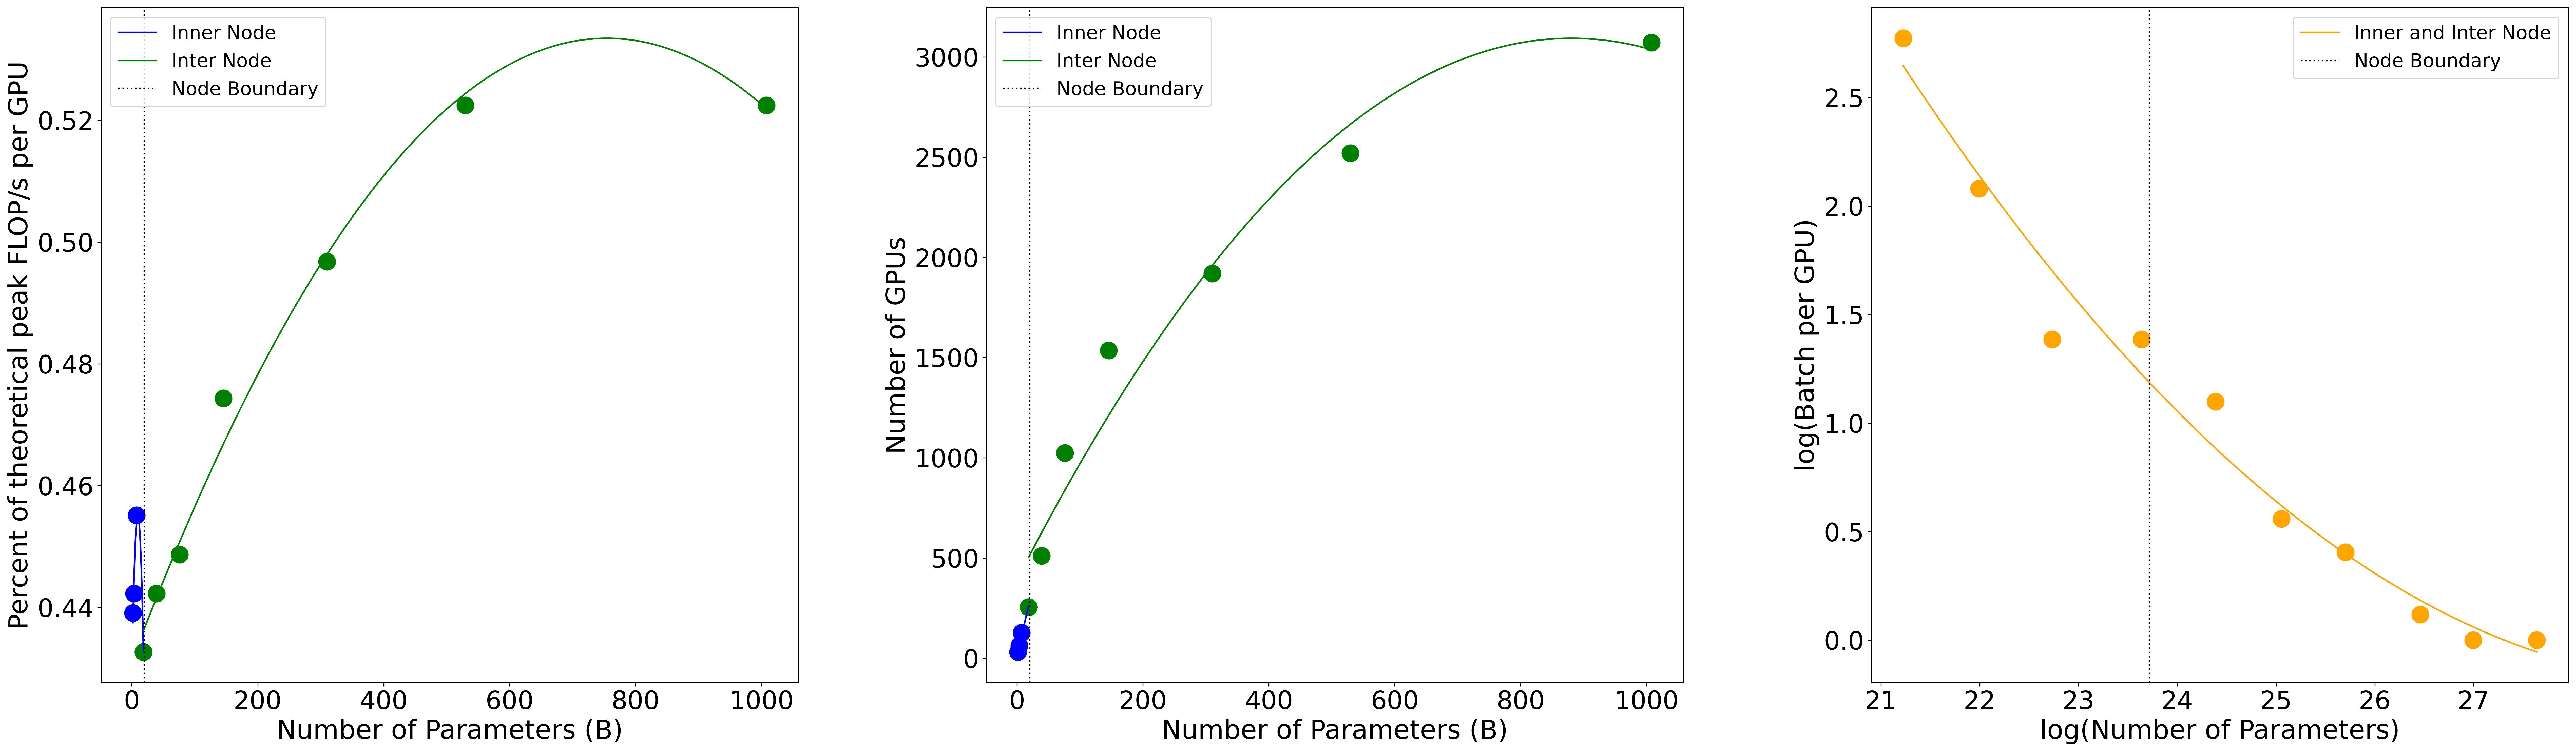

In [39]:
# Combined graph
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(34,10), dpi=300)
axes = axes.flatten()

def b_format(x, pos):
    return f'{int(x/1e9)}'

for ax in axes[:-1]:
    ax.xaxis.set_major_formatter(FuncFormatter(b_format))
    
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), fontsize=25)
    ax.set_ylabel(ax.get_ylabel(), fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=24)

range_tensor = intra_data['P_dense']
range_pipe = pipe_data['P_dense']
x_tensor = np.linspace(min(range_tensor), max(range_tensor), 100)
y_tensor = func_tensor(x_tensor)
x_pipe = np.linspace(min(range_pipe), max(range_pipe), 100)
y_pipe = func_pipe(x_pipe)

axes[0].scatter(range_tensor, intra_data['achieved_teraFLOPs_per_gpu']/gpu_map[gpu_type]['peak_flop'], marker='o', color='blue', s=250)
axes[0].scatter(range_pipe, pipe_data['achieved_teraFLOPs_per_gpu']/gpu_map[gpu_type]['peak_flop'], marker='o', color='green', s=250)
axes[0].plot(x_tensor, y_tensor/gpu_map[gpu_type]['peak_flop'], color='blue', label='Inner Node')
axes[0].plot(x_pipe, y_pipe/gpu_map[gpu_type]['peak_flop'], color='green', label='Inter Node')
axes[0].set_xlabel('Number of Parameters (B)')
axes[0].set_ylabel('Percent of theoretical peak FLOP/s per GPU')
# axes[0].set_title('Intra(CVRMSE: {:.2f}); Inter(CVRMSE: {:.2f})'.format(cvrmse_tensor, cvrmse_pipe), fontsize=24)
# Boundary split for tensor vs pipe degree
boundary_x = 20e9  # parameter boundary value(20B)
axes[0].axvline(x=boundary_x, color='black', linestyle='dotted', label='Node Boundary')
axes[0].legend(loc='upper left', fontsize=18)


range_gpu = intra_data['P_dense']
range_gpu_i = pipe_data['P_dense']
x_gpu = np.linspace(min(range_gpu), max(range_gpu), 100)
y_gpu = func_gpu(x_gpu)
x_gpu_i = np.linspace(min(range_gpu_i), max(range_gpu_i), 100)
y_gpu_i = func_gpu_i(x_gpu_i)

axes[1].scatter(range_gpu, intra_data['#gpus'], marker='o', color='blue', s=250)
axes[1].scatter(range_gpu_i, pipe_data['#gpus'], marker='o', color='green', s=250)
axes[1].plot(x_gpu, y_gpu, color='blue', label='Inner Node')
axes[1].plot(x_gpu_i, y_gpu_i, color='green', label='Inter Node')
axes[1].set_xlabel('Number of Parameters (B)')
axes[1].set_ylabel('Number of GPUs')
# axes[1].set_title('Intra(CVRMSE: {:.2f}); Inter(CVRMSE: {:.2f})'.format(cvrmse_gpu, cvrmse_gpu_i), fontsize=24)
# Boundary split for tensor vs pipe degree
boundary_x = 20e9  # parameter boundary value(20B)
axes[1].axvline(x=boundary_x, color='black', linestyle='dotted', label='Node Boundary')
axes[1].legend(loc='upper left', fontsize=18)


range_batch = scale_data['P_dense']
# Log transform
log_range_batch = np.log(range_batch)
x_batch = np.linspace(min(log_range_batch), max(log_range_batch), 100)
y_batch = func_batch(x_batch)

axes[2].scatter(log_range_batch, np.log(scale_data['batch_gpu']), marker='o', color='orange', s=250)
axes[2].plot(x_batch, y_batch, color='orange', label='Inner and Inter Node')
axes[2].set_xlabel('log(Number of Parameters)')
axes[2].set_ylabel('log(Batch per GPU)')
# axes[2].set_title('Full(CVRMSE: {:.2f})'.format(cvrmse_batch), fontsize=24)
# Boundary split for tensor vs pipe degree
boundary_x = np.log(20e9)  # parameter boundary value log(20B)
axes[2].axvline(x=boundary_x, color='black', linestyle='dotted', label='Node Boundary')
axes[2].legend(loc='upper right', fontsize=18)

# fig.suptitle('P/T; Number of GPUs; Batch Size against the total model parameter size')
plt.tight_layout()
fig.subplots_adjust(wspace=0.27)

plt.savefig('ml_para_set_1.pdf')
plt.show()
plt.close()

### Appendix

Regression functions

In [13]:
#intra_data condition -> P(B) < 20 else inter_data
#pipeline_data condition -> Tensor_Parallel >= 8 (include data at t=8;p=1)
#gpu_data 
intra_data = scale_data[scale_data['#parameters'] < 20]
inter_data = scale_data[scale_data['#parameters'] > 20]

pipe_data = scale_data[scale_data['tensor_model_size'] >= 8] 
gpu_data = scale_data[scale_data['#parameters'] > 70]
batch_data = scale_data[(scale_data['pipeline_model_size'] >= 1) & (scale_data['tensor_model_size'] >= 8)]

tensor_size = intra_data['tensor_model_size']

pipe_throughput = pipe_data['%_peak']
pipe_util = pipe_data['%_of_theoretical_peak']
pipe_size = pipe_data['pipeline_model_size']

data_size = pipe_data['data_model_size']


intra_parameters = intra_data['#parameters']
intra_throughput = intra_data['%_peak']
intra_util = intra_data['%_of_theoretical_peak']

inter_parameters = inter_data['#parameters']
inter_throughput = inter_data['achieved_teraFLOPs_per_gpu']
inter_util = inter_data['%_of_theoretical_peak']

tensor_size = intra_data['tensor_model_size']
peak_flop = 312

In [15]:
def get_cvrmse(est, act):
    mse = np.mean((est - act)**2)
    var = np.var(act)
    return np.sqrt(mse/var)

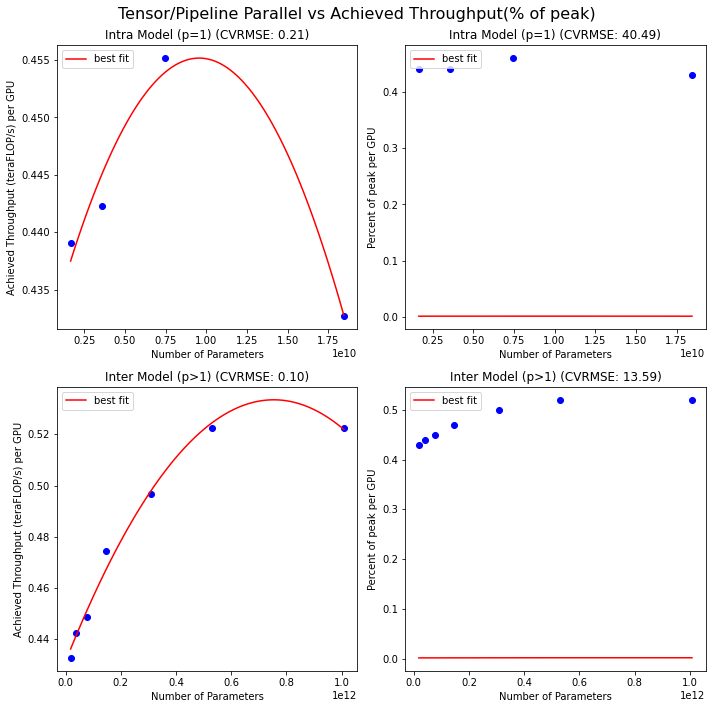

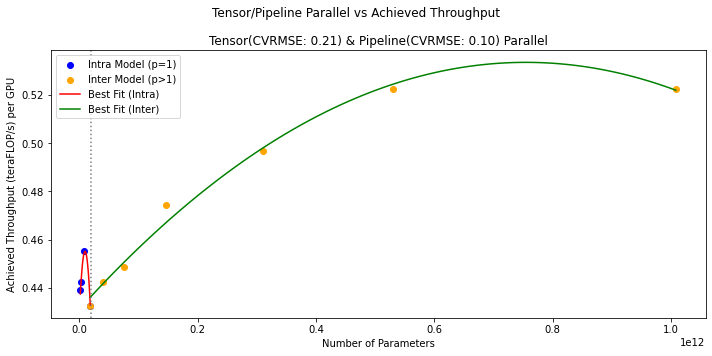

In [17]:
#polynomial(2d) regression - tensor parallel
range_tensor = intra_data['P_dense']
coeff_tensor = np.polyfit(range_tensor, intra_throughput, 2)
func_tensor = np.poly1d(coeff_tensor)
x_tensor = np.linspace(min(range_tensor), max(range_tensor), 100)
y_tensor = func_tensor(x_tensor)
#percent of peak here is basis estimated throughput value over peak capacity
y_tensor_util = y_tensor/peak_flop
y_tensor_valid = func_tensor(range_tensor)
y_tensor_util_valid = y_tensor_valid/peak_flop
cvrmse_tensor = get_cvrmse(y_tensor_valid, intra_throughput)
cvrmse_tensor_util = get_cvrmse(y_tensor_util_valid, intra_util)

#polynomial(2d) regression - pipe parallel
range_pipe = pipe_data['P_dense']
coeff_pipe = np.polyfit(range_pipe, pipe_throughput, 2)
func_pipe = np.poly1d(coeff_pipe)
x_pipe = np.linspace(min(range_pipe), max(range_pipe), 100)
y_pipe = func_pipe(x_pipe)
y_pipe_util = y_pipe/peak_flop
y_pipe_valid = func_pipe(range_pipe)
y_pipe_util_valid = y_pipe_valid/peak_flop
cvrmse_pipe = get_cvrmse(y_pipe_valid, pipe_throughput)
cvrmse_pipe_util = get_cvrmse(y_pipe_util_valid, pipe_util)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()

# Intra Model(p=1)
axes[0].scatter(range_tensor, intra_throughput, marker='o', color='blue')
axes[0].plot(x_tensor, y_tensor, color='red', label='best fit')
axes[0].set_xlabel('Number of Parameters')
axes[0].set_ylabel('Achieved Throughput (teraFLOP/s) per GPU')
axes[0].set_title('Intra Model (p=1) (CVRMSE: {:.2f})'.format(cvrmse_tensor))
axes[0].legend(loc='upper left')

axes[1].scatter(range_tensor, intra_util, marker='o', color='blue')
axes[1].plot(x_tensor, y_tensor_util, color='red', label='best fit')
axes[1].set_xlabel('Number of Parameters')
axes[1].set_ylabel('Percent of peak per GPU')
axes[1].set_title('Intra Model (p=1) (CVRMSE: {:.2f})'.format(cvrmse_tensor_util))
axes[1].legend(loc='upper left')

# Inter Model(p>1)
axes[2].scatter(range_pipe, pipe_throughput, marker='o', color='blue')
axes[2].plot(x_pipe, y_pipe, color='red', label='best fit')
axes[2].set_xlabel('Number of Parameters')
axes[2].set_ylabel('Achieved Throughput (teraFLOP/s) per GPU')
axes[2].set_title('Inter Model (p>1) (CVRMSE: {:.2f})'.format(cvrmse_pipe))
axes[2].legend(loc='upper left')

axes[3].scatter(range_pipe, pipe_util, marker='o', color='blue')
axes[3].plot(x_pipe, y_pipe_util, color='red', label='best fit')
axes[3].set_xlabel('Number of Parameters')
axes[3].set_ylabel('Percent of peak per GPU')
axes[3].set_title('Inter Model (p>1) (CVRMSE: {:.2f})'.format(cvrmse_pipe_util))
axes[3].legend(loc='upper left')

fig.suptitle('Tensor/Pipeline Parallel vs Achieved Throughput(% of peak)', fontsize=16)
plt.tight_layout()
plt.savefig('tp_parallel_throughput1.png')
plt.show()
plt.close()

# Combined graph
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(range_tensor, intra_throughput, marker='o', color='blue', label='Intra Model (p=1)')
ax.scatter(range_pipe, pipe_throughput, marker='o', color='orange', label='Inter Model (p>1)')
ax.plot(x_tensor, y_tensor, color='red', label='Best Fit (Intra)')
ax.plot(x_pipe, y_pipe, color='green', label='Best Fit (Inter)')
ax.set_xlabel('Number of Parameters')
ax.set_ylabel('Achieved Throughput (teraFLOP/s) per GPU')
ax.set_title('Tensor(CVRMSE: {:.2f}) & Pipeline(CVRMSE: {:.2f}) Parallel'.format(cvrmse_tensor, cvrmse_pipe))
ax.legend(loc='upper left')
# Boundary split for tensor vs pipe degree
boundary_x = 20e9  # parameter boundary value(20B)
ax.axvline(x=boundary_x, color='grey', linestyle='dotted')

fig.suptitle('Tensor/Pipeline Parallel vs Achieved Throughput')
plt.tight_layout()
# plt.savefig('tp_parallel_throughput.png')
plt.show()
plt.close()

In [18]:
coeff_tensor, coeff_pipe

(array([-2.82717650e-22,  5.40356141e-12,  4.29342100e-01]),
 array([-1.79562099e-25,  2.70972945e-13,  4.31237594e-01]))